<a href="https://colab.research.google.com/github/senthilkumar-dimitra/LULC-Classification-DL/blob/expts/LULC_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages
!pip install rasterio -q
!pip install earthpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.0 MB/s eta 0:00:00


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [ ]:
# Parameter
FEATURES = ['VV', 'VH','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9','B11', 'B12', 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev'] # 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev'
LABEL = ['class']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [0, 1, 2, 3, 4, 5]
PALETTE = ['006400', 'f096ff', '42c447', 'ffff4c', '0064c8','835313']
SAMPLE_PATH = '/content/drive/MyDrive/DL_LULC_Jambi_new/Samples_LC_Jambi_2023.csv'
IMAGE_PATH = '/content/drive/MyDrive/DL_LULC_Jambi_new/S1S2_Jambi_2023.tif'

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


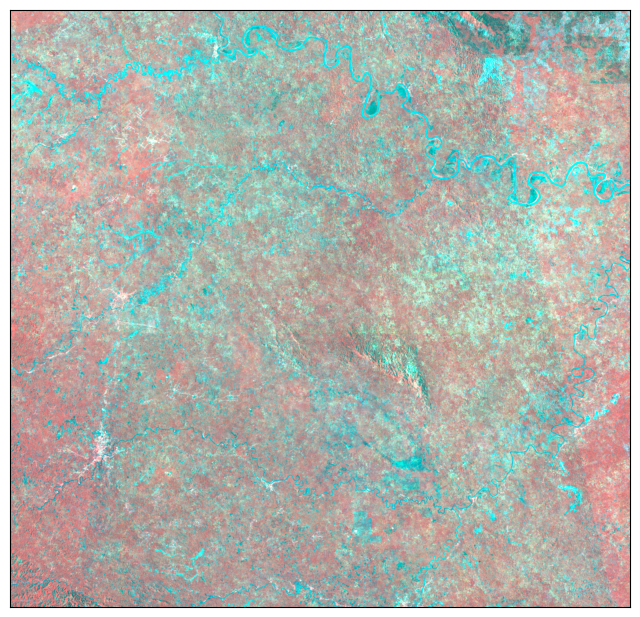

<Axes: >

In [ ]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [2,3,4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,VV,VH,B1,B2,B3,B4,B5,B6,B7,B8,...,ndvi,ndbi,mndwi,ndwi,bsi,evi,elev,slope,class,sample
5830,-7.804618,-14.538694,652.0,634.0,756.0,488.5,1071.0,3013.0,3882.5,3814.5,...,0.772949,-0.284668,-0.475000,-0.669183,-0.260020,4.175245,97,12.706659,3,train
7624,-22.318222,-25.672197,1112.0,1212.5,2102.0,2362.0,2238.0,1517.0,1602.0,1159.5,...,-0.341474,-0.677396,0.808172,0.288977,0.042970,-0.481867,79,0.927939,4,train
3892,-8.315353,-15.891180,832.0,826.0,1142.0,1283.0,1705.0,2862.0,3298.0,3086.0,...,0.412680,-0.021854,-0.442383,-0.459792,0.039882,0.982026,82,4.721053,1,train
7353,-8.014511,-16.146666,478.0,483.0,660.0,402.5,919.0,2918.0,3769.0,3639.5,...,0.800841,-0.316275,-0.482454,-0.692988,-0.285169,3.326141,59,3.818640,3,test
4405,-11.688970,-18.683744,1202.5,1098.5,1347.0,1340.5,1935.5,3021.0,3408.0,3177.5,...,0.406596,0.009121,-0.412175,-0.404575,0.033945,1.539687,94,7.030117,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,-8.217632,-14.035062,905.0,915.5,1332.5,1351.5,1895.5,2930.5,3368.5,3201.0,...,0.406260,-0.041399,-0.377191,-0.412154,0.021570,1.040272,125,8.685021,1,train
4016,-9.181992,-16.411438,841.0,881.0,1111.5,1299.5,1685.0,2487.5,2798.0,2734.5,...,0.355726,0.114547,-0.511804,-0.421997,0.134737,0.914013,80,6.198182,1,train
656,-8.817267,-13.929762,625.0,634.0,780.0,556.0,1212.0,2958.0,3636.0,3471.0,...,0.723864,-0.157772,-0.527988,-0.633027,-0.142499,3.549683,59,6.721414,0,train
7925,-6.217396,-12.324195,830.5,886.0,1088.0,1139.0,1607.0,2288.0,2521.0,2459.5,...,0.366958,0.045410,-0.424567,-0.386610,0.067846,1.245990,65,0.927960,5,train


In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (7162, 21, 1)
Test features: (869, 21, 1)
Train label: (7162, 6)
Test label: (869, 6)


In [ ]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 128
drop = 0.2
kernel = 3
pool = 1

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
  Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
  Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 21, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 21, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 256)           98560     
                                                                 
 conv1d_3 (Conv1D)           (None, 21, 256)           196864    
                                                        

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=32,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
224/224 [==============================] - 17s 62ms/step - loss: 5.8837 - accuracy: 0.5468 - val_loss: 0.8936 - val_accuracy: 0.5201
Epoch 2/100
224/224 [==============================] - 14s 60ms/step - loss: 0.7862 - accuracy: 0.6811 - val_loss: 0.8543 - val_accuracy: 0.4327
Epoch 3/100
224/224 [==============================] - 14s 64ms/step - loss: 0.6628 - accuracy: 0.7390 - val_loss: 0.8562 - val_accuracy: 0.6502
Epoch 4/100
224/224 [==============================] - 15s 67ms/step - loss: 0.5749 - accuracy: 0.7885 - val_loss: 0.7287 - val_accuracy: 0.7376
Epoch 5/100
224/224 [==============================] - 16s 70ms/step - loss: 0.5698 - accuracy: 0.7820 - val_loss: 0.6003 - val_accuracy: 0.7940
Epoch 6/100
224/224 [==============================] - 15s 66ms/step - loss: 0.5186 - accuracy: 0.8101 - val_loss: 0.8700 - val_accuracy: 0.6214
Epoch 7/100
224/224 [==============================] - 15s 65ms/step - loss: 0.5240 - accuracy: 0.8126 - val_loss: 0.7022 - val_ac

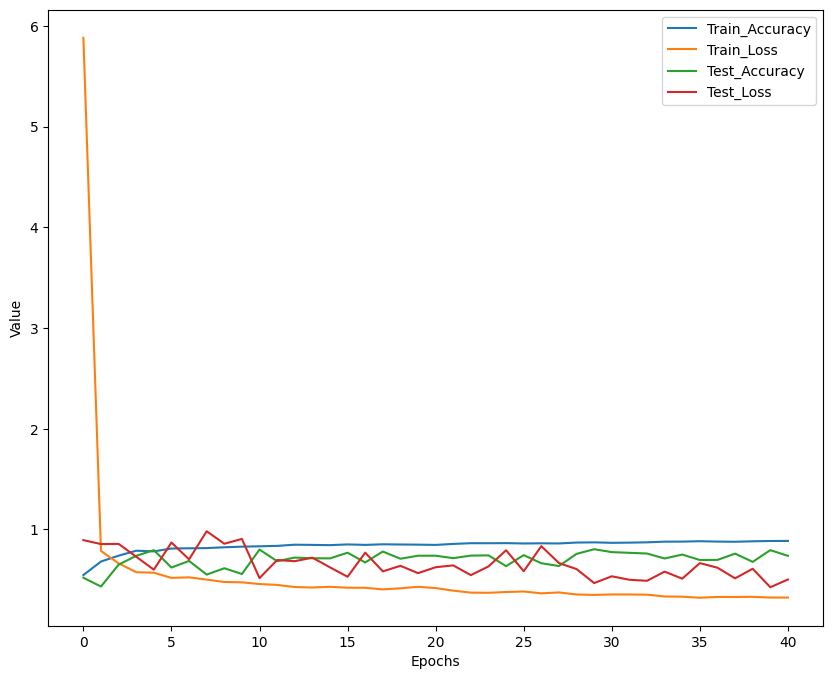

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

28/28 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.61      0.99      0.75       298
           1       0.09      0.17      0.12        18
           2       0.98      0.84      0.91       134
           3       0.98      0.55      0.70       388
           4       1.00      1.00      1.00        10
           5       1.00      0.43      0.60        21

    accuracy                           0.74       869
   macro avg       0.78      0.66      0.68       869
weighted avg       0.84      0.74      0.74       869



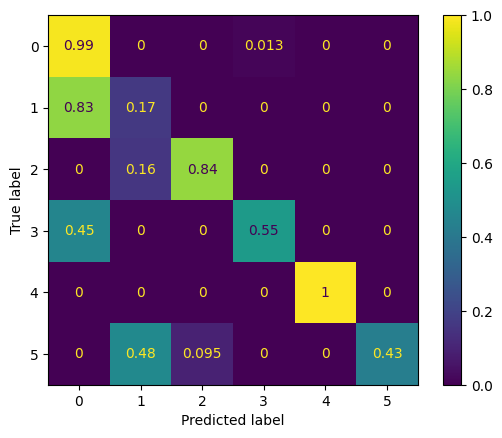

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

In [ ]:
# Predict image using the model
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

132/132 [==============================] - 2631s 20s/step


ValueError: Invalid string grayscale value '835313'. Value must be within 0-1 range

In [ ]:
# Save file to drive
save_location = '/content/drive/MyDrive/DL_LULC_Jambi_new/'
name = 'LC_Jambi_2023.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()